<a href="https://colab.research.google.com/github/mounbagna/Aspect-Based-Sentiment-Analysis-Of-The-Hausa-Language/blob/main/ABSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [8]:
!pip install keras --quiet

In [9]:
!pip install transformers datasets scikit-learn --quiet

In [10]:
pip install nltk --quiet


In [11]:
pip install matplotlib --quiet


In [12]:
pip install --upgrade ipywidgets --quiet


In [13]:
pip install --upgrade jupyter --quiet


In [14]:
pip install tensorflow --quiet


In [15]:
pip install torch torchvision torchaudio --quiet

In [16]:
pip install seaborn --quiet


In [17]:
pip install wordcloud --quiet


In [18]:
pip install openpyxl


In [19]:
pip install hf_xet


In [20]:
import os
import pandas as pd
import numpy as np
import nltk
import tensorflow as tf
import torch
import seaborn as sns

from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForTokenClassification, BertForSequenceClassification
from torch.optim import AdamW
from datasets import Dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
#from google.colab import files
from keras.layers import Dense, Embedding, SimpleRNN, Dropout
from keras.models import load_model, Model
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D,Bidirectional, LSTM, MaxPooling1D, Flatten, Dense
from google.colab import files

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Preprocessing Functions**

In [21]:
def remove_stopwords(sentence, stopwords):
    if not isinstance(sentence, str):  # Check if the sentence is a string
        return ""  # Return an empty string if the sentence is not a string
    words = sentence.lower().split()
    words = [word for word in words if word not in stopwords]
    return " ".join(words)

def tokenize(sentence):
    return word_tokenize(sentence)

def calculate_polarity(polarity_value):
    """Map the polarity value to a label."""
    polarity_map = {
        1: "Negative",
        2: "Neutral",
        3: "Positive"
    }
    return polarity_map.get(polarity_value, "Unknown")  # Default to "Unknown" if value is not 1, 2, or 3

def remove_gender_marker(text):
    words = text.split()  # Split the text into words
    processed_words = []  # List to store processed words

    for word in words:
        if len(word) > 3:
            last_letter = word[-1]
            pre_last_letter = word[-2] if len(word) > 1 else None

            if last_letter == 'r':
                # Check if second last letter is 'u' or not 'i'
                if pre_last_letter == 'u' or pre_last_letter != 'i':
                    # Remove the last letter
                    processed_words.append(word[:-1])
                else:
                    processed_words.append(word)  # Keep the word
            elif last_letter == 'n':
                # Remove the last letter if the last letter is 'n'
                processed_words.append(word[:-1])
            else:
                processed_words.append(word)  # Keep the word
        else:
            processed_words.append(word)  # Keep the word if its length is <= 3

    return " ".join(processed_words)  # Join the processed words back into a sentence

def remove_suffix_prefix(text):
    words = text.split()  # Split the text into words
    processed_words = []  # List to store processed words

    for word in words:
        if len(word) > 3:
            # Check if the word begins with specific prefixes
            if word.startswith(('ba', 'ma', 'mai', 'yan')):
                last_two_letters = word[-2:]
                last_three_letters = word[-3:]
                last_four_letters = word[-4:]

                if last_two_letters == 'wa':
                    # Remove first two and last two letters
                    processed_words.append(word[2:-2])
                elif last_three_letters in ('iya', 'uwa', 'kku'):
                    # Remove first two and last three letters
                    processed_words.append(word[2:-3])
                elif last_four_letters == 'anya':
                    # Remove first two and last four letters
                    processed_words.append(word[2:-4])
                else:
                    processed_words.append(word)  # Keep the word
            else:
                processed_words.append(word)  # Keep the word if no matching prefix
        else:
            processed_words.append(word)  # Keep the word if its length is <= 3

    return " ".join(processed_words)  # Join the processed words back into a sentence

def remove_infix(text):
    words = text.split()  # Split the text into words
    processed_words = []  # List to store processed words

    for word in words:
        if len(word) > 3:
            # Check if the fourth-from-last letter is the same as the second-from-last letter,
            # the third-from-last letter is 'o', and the last letter is 'i'
            if (word[-4] == word[-2]) and (word[-3] == 'o') and (word[-1] == 'i'):
                # Remove the last four letters and add 'a' to the end
                processed_words.append(word[:-4] + 'a')
            else:
                processed_words.append(word)  # Keep the word
        else:
            processed_words.append(word)  # Keep the word if its length is <= 3

    return " ".join(processed_words)  # Join the processed words back into a sentence

def preprocess_sentence(sentence):
    # Step 1: Remove stopwords
    cleaned_sentence = remove_stopwords(sentence, stopwords)

    # Step 2: Apply gender marker removal
    cleaned_sentence = remove_gender_marker(cleaned_sentence)

    # Step 3: Apply suffix-prefix removal
    cleaned_sentence = remove_suffix_prefix(cleaned_sentence)

    # Step 4: Apply infix removal
    cleaned_sentence = remove_infix(cleaned_sentence)

    return cleaned_sentence


**Create Folders**

In [19]:
ds = "hesac_dataset"
os.makedirs(ds, exist_ok=True)
print(f"Folder '{ds}' created successfully.")

sw = "stopwords"
os.makedirs(sw, exist_ok=True)
print(f"Folder '{sw}' created successfully.")

Folder 'hesac_dataset' created successfully.
Folder 'stopwords' created successfully.


**Upload Files**

In [43]:
uploaded = files.upload()

**Loading the Dataset**

In [22]:
# Load dataset
df = pd.read_excel('./hesac_dataset/hesac.xlsx')

with open("./stopwords/StopWords-HA.txt", "r") as file:
    stopwords = file.read().splitlines()


/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [23]:
# Calculate the total number of sentences in the dataset
total_stopWords = len(stopwords)
total_sentences = len(df)

# Print the total number of sentences in each dataset
print(f"Total number of stopwords: {total_stopWords}")
print(f"Total number of sentences in the dataset: {total_sentences}")

Total number of stopwords: 150
Total number of sentences in the dataset: 10000


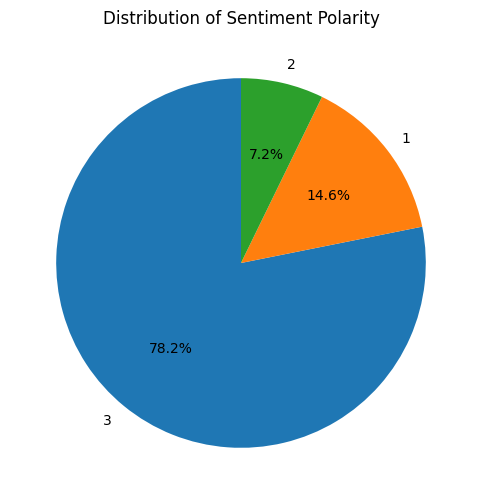

In [26]:
polarity_counts = df['Polarity'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=90)
_ = plt.title('Distribution of Sentiment Polarity')

In [25]:
# Count occurrences of each aspect category
aspect_counts = df['Aspect Category'].value_counts()
print("Aspect Category counts:")
print(aspect_counts)

# Count occurrences of each polarity
polarity_counts = df['Polarity'].value_counts()
print("\nPolarity counts:")
print(polarity_counts)


Aspect Category counts:
Aspect Category
course content                       3810
lecturer behavior                    2613
teaching quality                     1655
teaching performance                 1216
course content                        349
course difficulty                     324
course content,  teaching quality       8
course  content                         7
 course content                         4
 teaching quality                       3
course quality                          3
lecturer behaviour                      3
teaching quality                        2
teaching perfromance                    2
 teaching performance                   1
Name: count, dtype: int64

Polarity counts:
Polarity
3    7815
1    1463
2     722
Name: count, dtype: int64


In [27]:
# Mapping of incorrect or similar labels to standardized ones
aspect_correction = {
    "course content": "course content",
    "course  content": "course content",
    " course content": "course content",
    "course content,  teaching quality": "course content",
    "course difficulty": "course difficulty",
    "teaching quality": "teaching quality",
    " teaching quality": "teaching quality",
    "teaching perfromance": "teaching performance",
    " teaching performance": "teaching performance",
    "teaching performance": "teaching performance",
    "lecturer behavior": "lecturer behavior",
    "lecturer behaviour": "lecturer behavior",
    "course quality": "course content"  # assuming it's similar
}


In [28]:
df['Aspect Category'] = df['Aspect Category'].map(aspect_correction).fillna(df['Aspect Category'])
df['Aspect Category'] = df['Aspect Category'].str.strip().str.lower()


In [29]:
# Count occurrences of each aspect category
aspect_counts = df['Aspect Category'].value_counts()
print("Aspect Category counts:")
print(aspect_counts)

# Count occurrences of each polarity
polarity_counts = df['Polarity'].value_counts()
print("\nPolarity counts:")
print(polarity_counts)


Aspect Category counts:
Aspect Category
course content          4181
lecturer behavior       2616
teaching quality        1660
teaching performance    1219
course difficulty        324
Name: count, dtype: int64

Polarity counts:
Polarity
3    7815
1    1463
2     722
Name: count, dtype: int64


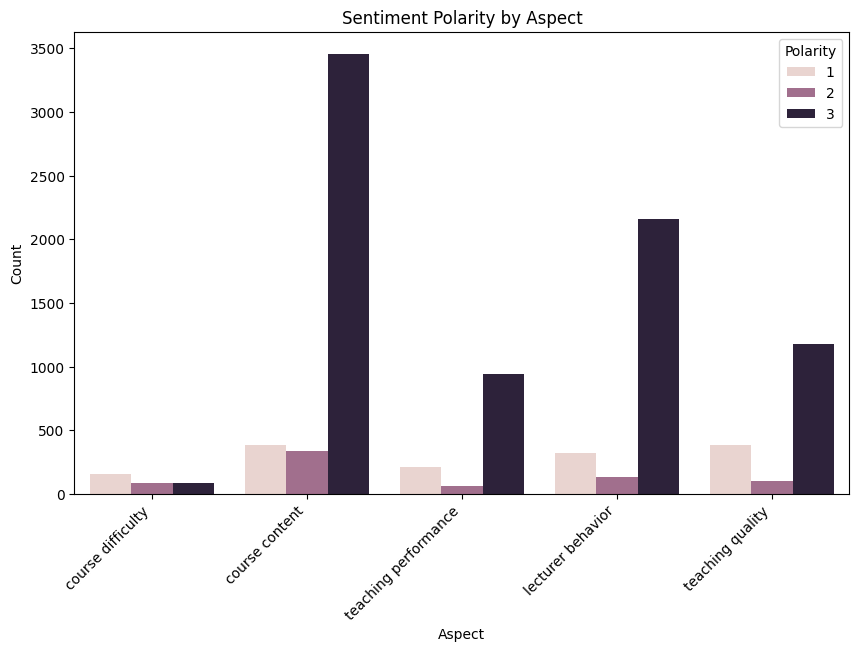

In [30]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Aspect Category', hue='Polarity', data=df)
plt.title('Sentiment Polarity by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


**Preprocessing Data**

In [31]:
# Normalize 'Aspect_words' column
if 'Aspect Category' in df.columns:
    df['Aspect Category'] = (
        df['Aspect Category']
        .str.strip()  # Remove leading and trailing spaces
        .str.lower()  # Convert to lowercase
        .str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
        .str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space
    )

# Remove trailing periods and extra spaces in all columns
df = df.map(
    lambda x: x.strip().rstrip('.') if isinstance(x, str) else x
)

# Normalize 'Comment' column
if 'Hausa' in df.columns:
    df['Hausa'] = (
        df['Hausa']
        .str.strip()  # Remove leading and trailing spaces
        .str.lower()  # Convert to lowercase
        .str.replace(r'[^\w\s]', '', regex=True)  # Remove punctuation
        .str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space
    )
data = []
for _, row in df.iterrows():
    sentence = row['Hausa']
    polarity_value = row['Polarity']
    aspect_category = row['Aspect Category']

    # Apply all preprocessing steps here
    cleaned_sentence = preprocess_sentence(sentence)

    polarity_label = calculate_polarity(polarity_value)
    data.append({
        'sentence': sentence,
        'cleaned_sentence': cleaned_sentence,
        'aspect_category': aspect_category,
        'polarity': polarity_label
    })

processed_df = pd.DataFrame(data)

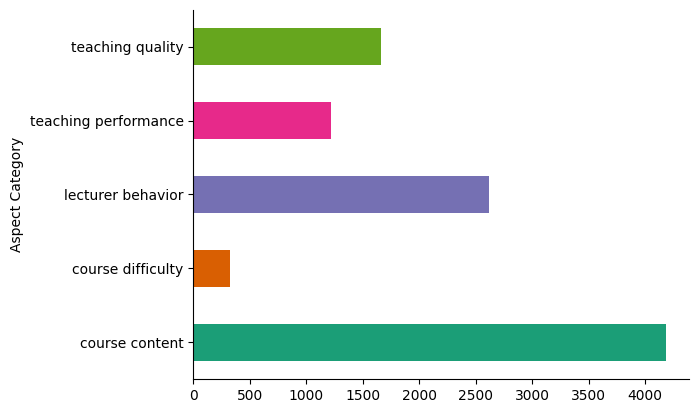

In [32]:
df.groupby('Aspect Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

**Extracting Columns and Encoding**

In [33]:
hausa_text = processed_df['cleaned_sentence']
aspect_category = df['Aspect Category']
polarity = df['Polarity']

# Encode the aspect category and polarity columns
aspect_encoder = LabelEncoder()
polarity_encoder = LabelEncoder()

aspect_labels = aspect_encoder.fit_transform(aspect_category)
polarity_labels = polarity_encoder.fit_transform(polarity)

**Splitting the Dataset**

In [34]:
x_train, x_test, y_train_aspect_raw, y_test_aspect_raw = train_test_split(
    hausa_text,
    aspect_labels,
    test_size=0.2,
    random_state=42
)

_, _, y_train_polarity_raw, y_test_polarity_raw = train_test_split(
    hausa_text,
    polarity_labels,
    test_size=0.2,
    random_state=42
)

**Tokenization and Padding**

In [35]:
# Tokenizer parameters
max_words = 2000
max_sequence_length = 100

# Initialize and fit tokenizer on training text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

# Convert text to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences to the same length
x_train_padded = pad_sequences(x_train_seq, maxlen=max_sequence_length)
x_test_padded = pad_sequences(x_test_seq, maxlen=max_sequence_length)

**One-Hot Encoding of Labels**

In [36]:
# Determine the number of unique classes
num_aspect_classes = len(set(y_train_aspect_raw))
num_polarity_classes = len(set(y_train_polarity_raw))

# One-hot encode the labels
y_train_aspect = to_categorical(y_train_aspect_raw, num_classes=num_aspect_classes)
y_test_aspect = to_categorical(y_test_aspect_raw, num_classes=num_aspect_classes)

y_train_polarity = to_categorical(y_train_polarity_raw, num_classes=num_polarity_classes)
y_test_polarity = to_categorical(y_test_polarity_raw, num_classes=num_polarity_classes)


**Defining the BiLSTM Model**

In [37]:
def BiLSTM(max_sequence_length, max_words, embedding_dim, num_aspect_classes, num_polarity_classes):
    input_layer = Input(shape=(max_sequence_length,))
    embedding_layer = Embedding(input_dim=max_words,
                                 output_dim=embedding_dim)(input_layer)
    bilstm_layer_1 = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
    dropout_layer_1 = Dropout(0.3)(bilstm_layer_1)

    bilstm_layer_2 = Bidirectional(LSTM(64))(dropout_layer_1)
    dropout_layer_2 = Dropout(0.3)(bilstm_layer_2)

    aspect_output = Dense(num_aspect_classes, activation='softmax', name='aspect_output')(dropout_layer_2)
    polarity_output = Dense(num_polarity_classes, activation='softmax', name='polarity_output')(dropout_layer_2)

    # Create model
    model = Model(inputs=input_layer, outputs=[aspect_output, polarity_output])

    model.compile(
        optimizer='adam',
        loss={
            'aspect_output': 'categorical_crossentropy',
            'polarity_output': 'categorical_crossentropy'
        },
        metrics={
            'aspect_output': 'accuracy',
            'polarity_output': 'accuracy'
        }
    )

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5),
        ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
    ]

    return model, callbacks

**Training**

In [64]:
# Define parameters for the model
max_sequence_length = 100
max_words = 10000
embedding_dim = 300
num_aspect_classes = 5
num_polarity_classes = 3

# Create the model and callbacks
model, callbacks = BiLSTM(max_sequence_length, max_words, embedding_dim, num_aspect_classes, num_polarity_classes)

# Train the model with validation split
history = model.fit(
    x_train_padded,
    {'aspect_output': y_train_aspect,
     'polarity_output': y_train_polarity},
    validation_split=0.2,
    epochs=15,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 942ms/step - aspect_output_accuracy: 0.4174 - aspect_output_loss: 1.3815 - loss: 2.0822 - polarity_output_accuracy: 0.7597 - polarity_output_loss: 0.7007 - val_aspect_output_accuracy: 0.5919 - val_aspect_output_loss: 1.0223 - val_loss: 1.5143 - val_polarity_output_accuracy: 0.8163 - val_polarity_output_loss: 0.4921
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 139s 917ms/step - aspect_output_accuracy: 0.6064 - aspect_output_loss: 0.9997 - loss: 1.4809 - polarity_output_accuracy: 0.8280 - polarity_output_loss: 0.4812 - val_aspect_output_accuracy: 0.6450 - val_aspect_output_loss: 0.9172 - val_loss: 1.3370 - val_polarity_output_accuracy: 0.8419 - val_polarity_output_loss: 0.4198
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 913ms/step - aspect_output_accuracy: 0.6777 - aspect_output_loss: 0.8454 - loss: 1.2401 - polarity_output_accuracy: 0.8637 - polarity_output_loss: 0.3947 - val_aspect_output_accuracy: 0.6538 - val_aspect_output_loss: 0.8871 - val_l

**Evaluation**

In [65]:
# Evaluate the model and print metrics
results = model.evaluate(
    x_test_padded,
    {'aspect_output': y_test_aspect, 'polarity_output': y_test_polarity},
    verbose=1
)

print(f"Evaluation results: {results}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step - aspect_output_accuracy: 0.6785 - aspect_output_loss: 0.9287 - loss: 1.4420 - polarity_output_accuracy: 0.8526 - polarity_output_loss: 0.5133
Evaluation results: [1.4449087381362915, 0.9444423317909241, 0.49805349111557007, 0.6669999957084656, 0.8600000143051147]


**Performance Evaluation for Aspect and Polarity Predictions**

In [66]:
# Get predictions for calculating precision, recall, f1, etc.
y_pred_aspect, y_pred_polarity = model.predict(x_test_padded)

# Convert predictions from one-hot encoding to class labels
y_pred_aspect_labels = np.argmax(y_pred_aspect, axis=1)
y_pred_polarity_labels = np.argmax(y_pred_polarity, axis=1)

# Convert ground truth from one-hot encoding to class labels
y_test_aspect_labels = np.argmax(y_test_aspect, axis=1)
y_test_polarity_labels = np.argmax(y_test_polarity, axis=1)

# Calculate Aspect metrics
aspect_accuracy = accuracy_score(y_test_aspect_labels, y_pred_aspect_labels)
aspect_precision = precision_score(y_test_aspect_labels, y_pred_aspect_labels, average='weighted')
aspect_recall = recall_score(y_test_aspect_labels, y_pred_aspect_labels, average='weighted')
aspect_f1 = f1_score(y_test_aspect_labels, y_pred_aspect_labels, average='weighted')

# Print Aspect metrics
print("\nAspect metrics:")
print(f"Accuracy: {aspect_accuracy}")
print(f"Precision: {aspect_precision}")
print(f"Recall: {aspect_recall}")
print(f"F1 Score: {aspect_f1}")

# Calculate Polarity metrics
polarity_accuracy = accuracy_score(y_test_polarity_labels, y_pred_polarity_labels)
polarity_precision = precision_score(y_test_polarity_labels, y_pred_polarity_labels, average='weighted')
polarity_recall = recall_score(y_test_polarity_labels, y_pred_polarity_labels, average='weighted')
polarity_f1 = f1_score(y_test_polarity_labels, y_pred_polarity_labels, average='weighted')

# Print Polarity metrics
print("\nPolarity metrics:")
print(f"Accuracy: {polarity_accuracy}")
print(f"Precision: {polarity_precision}")
print(f"Recall: {polarity_recall}")
print(f"F1 Score: {polarity_f1}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step

Aspect metrics:
Accuracy: 0.667
Precision: 0.6569314671264744
Recall: 0.667
F1 Score: 0.6546974045429967

Polarity metrics:
Accuracy: 0.86
Precision: 0.8498067373210982
Recall: 0.86
F1 Score: 0.8526344527488127


**Hausa Bidirectional Encoder Representations from Transformers (HauBERT)**

In [38]:
# Define a mapping function to convert the polarity labels
def encode_polarity(polarity):
    mapping = {
        3: 1,
        2: 0,
        1: 2
    }
    return mapping.get(int(polarity), -1)  # Convert to int and default to -1 for unknown labels

# Apply the encoding function to the 'Polarity' column
df['Polarity_Encoded'] = df['Polarity'].apply(encode_polarity)

# Display the first few rows of the updated DataFrame
print(df[['Polarity', 'Polarity_Encoded']].head())


   Polarity  Polarity_Encoded
0         1                 2
1         3                 1
2         3                 1
3         3                 1
4         3                 1


**Aspect-Based Annotation of Hausa Comments Using Rule-Based Keyword Matching**

In [39]:
# Updated aspect categorization function based on content and name matching
def annotate_aspect(comment, aspect_category):
    """
    Annotates a comment with BIO tags based on aspect categories.

    Args:
        comment (str): The input comment.
        aspect_category (str): The aspect category.

    Returns:
        dict: Tokenized words and their BIO tags.
    """
    words = comment.split()
    tags = []

    # Check the aspect category based on the given aspect_category
    if aspect_category == "course content":
        tags = ['B-course content'] + ['I-course content'] * (len(words) - 1)
    elif aspect_category == "teaching performance":
        tags = ['B-teaching performance'] + ['I-teaching performance'] * (len(words) - 1)
    elif aspect_category == "teaching quality":
        tags = ['B-teaching quality'] + ['I-teaching quality'] * (len(words) - 1)
    elif aspect_category == "lecturer behavior":
        tags = ['B-lecturer behavior'] + ['I-lecturer behavior'] * (len(words) - 1)
    elif aspect_category == "course difficulty":
        tags = ['B-course difficulty'] + ['I-course difficulty'] * (len(words) - 1)
    else:
        tags = ['O'] * len(words)  # Other case if the category is unknown

    return {"words": words, "tags": tags}

# Function to determine aspect category based on content and name list matching
def determine_aspect_category(comment):
    """
    Determines the aspect category of a comment using keyword matching.

    Args:
        comment (str): The input comment.

    Returns:
        str: The determined aspect category.
    """
    if "course" in comment or "content" in comment or "it" in comment:
        return "course content"
    elif "hard" in comment or "easy" in comment or "difficult" in comment:
        return "course difficulty"
    elif "good man" in comment or "good lecturer" in comment or "respect" in comment:
        return "lecturer behavior"
    elif "good job" in comment or "performance" in comment or "keep it up" in comment:
        return "teaching performance"
    elif "explain" in comment or "teaches well" in comment:
        return "teaching quality"
    else:
        return None  # Default if no keywords match

# Assuming the DataFrame `df` has a column 'Hausa' containing the comments
# Create a new column to store aspect annotations
df['Hausa'] = df['Hausa'].fillna('').astype(str)
df['Annotations'] = [
    annotate_aspect(comment, determine_aspect_category(comment))
    for comment in df['Hausa']
]

# Display the annotated data
#for index, row in df.iterrows():
    #print(f"Hausa: {row['Hausa']}")
    #print(f"Words: {row['Annotations']['words']}")
    #print(f"Tags: {row['Annotations']['tags']}")
    #print()


**Preparation of Training and Testing Datasets for Sentiment Analysis Using Hugging Face Format**

In [42]:
# Split into train and test sets
train_texts, test_texts, train_annotations, test_annotations, train_sentiments, test_sentiments = train_test_split(
    df["Hausa"], df["Annotations"], df["Polarity_Encoded"], test_size=0.2, random_state=42
)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({
    "Hausa": train_texts.tolist(),
    "annotations": train_annotations.tolist(),
    "Polarity_Encoded": train_sentiments.tolist()
})
test_dataset = Dataset.from_dict({
    "Hausa": test_texts.tolist(),
    "annotations": test_annotations.tolist(),
    "Polarity_Encoded": test_sentiments.tolist()
})

# Display dataset samples
print("Train Dataset Sample:")
print(train_dataset[0])

print("\nTest Dataset Sample:")
print(test_dataset[0])


Train Dataset Sample:
{'Hausa': 'hanya ce mai kyau', 'annotations': {'tags': ['O', 'O', 'O', 'O'], 'words': ['hanya', 'ce', 'mai', 'kyau']}, 'Polarity_Encoded': 1}

Test Dataset Sample:
{'Hausa': 'kyakkyawan hanya ina kawai fata na wuce', 'annotations': {'tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O'], 'words': ['kyakkyawan', 'hanya', 'ina', 'kawai', 'fata', 'na', 'wuce']}, 'Polarity_Encoded': 1}


In [43]:
train_dataset

Dataset({
    features: ['Hausa', 'annotations', 'Polarity_Encoded'],
    num_rows: 8000
})

**Initializing Tokenizer and Pre-trained mBERT Models for Aspect Extraction and Sentiment Classification**

In [2]:
!pip install torch torchvision torchaudio --quiet


In [44]:
from transformers import BertTokenizer, BertForTokenClassification, BertForSequenceClassification

# Load mBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Load models for token classification (aspect extraction) and sequence classification (sentiment polarity)
aspect_model = BertForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=5  # Labels: B-Aspect, I-Aspect, O
)

sentiment_model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=3  # Sentiments: negative, neutral, positive
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Tokenization and Label Alignment using BERT for Hausa Sentiment Analysis**

In [45]:
from transformers import BertTokenizerFast

# Initialize tokenizer (we'll use mBERT tokenizer here)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")


def tokenize_and_align_labels(examples):
    # Tokenize the comments
    tokenized_inputs = tokenizer(examples["Hausa"], truncation=True, padding="max_length", max_length=128, is_split_into_words=False)

    # Align labels with tokenized inputs
    labels = []
    for i, label in enumerate(examples["annotations"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to words
        label_ids = []
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)  # Ignore special tokens (like [CLS], [SEP], padding)
            elif word_id != previous_word_id:  # First subword token
                label_ids.append(label[word_id])
            else:  # Subsequent subword token
                label_ids.append(label[word_id])
            previous_word_id = word_id
        labels.append(label_ids)

    # Return the tokenized inputs, labels, and sentiment (sentiment stays as a whole, not per token)
    tokenized_inputs["labels"] = labels
    tokenized_inputs["sentiments"] = examples["Polarity_Encoded"]  # Sentiment for the whole comment
    return tokenized_inputs


**Tokenization and BIO Tag Alignment for Aspect-Based Sentiment Analysis:**
This section defines a function to tokenize Hausa language comments and align the corresponding BIO tags (Begin, Inside, Outside) for teaching-related aspects such as teaching quality, teaching performance, and course difficulty. The labels are mapped to numerical values for model training. The function ensures correct alignment between tokens and tags after tokenization using a Hugging Face tokenizer.

In [46]:
# Create a mapping for BIO tags to numerical labels
tag2id = {'O': 0, 'B-teaching quality': 1, 'I-teaching quality': 1, 'B-teaching performance': 2, 'I-teaching performance': 2, 'B-course difficulty': 3, 'I-course difficulty': 3,
          'B-course content': 4, 'I-course content': 4, 'B-lecturer behavior': 4, 'I-lecturer behavior': 4}
id2tag = {id: tag for tag, id in tag2id.items()}

def tokenize_and_align_labels(examples):
    # Tokenize the comments
    tokenized_inputs = tokenizer(examples["Hausa"], truncation=True, padding="max_length", max_length=128, is_split_into_words=False)

    # Align labels with tokenized inputs
    labels = []
    for i, label in enumerate(examples["annotations"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to words
        label_ids = []
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)  # Ignore special tokens (like [CLS], [SEP], padding)
            elif word_id != previous_word_id:  # First subword token
                # Access the 'tags' list from the label dictionary
                # and adjust the index to match the token position
                if word_id < len(label['tags']):  # Check if word_id is within the bounds of tags
                    # Convert the BIO tag to its corresponding numerical label
                    label_ids.append(tag2id[label['tags'][word_id]])
                else:
                    label_ids.append(-100) # Assign -100 if word_id is out of bounds

            else:  # Subsequent subword token
                # Access the 'tags' list from the label dictionary
                # and adjust the index to match the token position
                if word_id < len(label['tags']): # Check if word_id is within the bounds of tags
                    # Convert the BIO tag to its corresponding numerical label
                    label_ids.append(tag2id[label['tags'][word_id]])
                else:
                    label_ids.append(-100)  # Assign -100 if word_id is out of bounds
            previous_word_id = word_id
        labels.append(label_ids)

    # Return the tokenized inputs, labels, and sentiment (sentiment stays as a whole, not per token)
    tokenized_inputs["labels"] = labels
    tokenized_inputs["sentiments"] = examples["Polarity_Encoded"]  # Sentiment for the whole comment
    return tokenized_inputs
train_tokenized = train_dataset.map(tokenize_and_align_labels, batched=True)
test_tokenized = test_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

**Conversion of Tokenized Dataset to TensorDataset and DataLoader Setup**

In [47]:
from torch.utils.data import TensorDataset
# Convert train and test datasets to PyTorch tensors
def convert_to_tensor_dataset(dataset):
    # Extract input IDs, attention masks, labels, and sentiments
    input_ids = torch.tensor(dataset['input_ids'])
    attention_masks = torch.tensor(dataset['attention_mask'])
    labels = torch.tensor(dataset['labels'])
    sentiments = torch.tensor(dataset['sentiments'])  # Sentiment labels

    return TensorDataset(input_ids, attention_masks, labels, sentiments)

# Convert both train and test datasets
train_tensor_dataset = convert_to_tensor_dataset(train_tokenized)
test_tensor_dataset = convert_to_tensor_dataset(test_tokenized)

# Create DataLoader for training and testing
train_loader = DataLoader(train_tensor_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_tensor_dataset, batch_size=8)


**Loading and Unpacking Batches for Model Training**

In [48]:
for batch in train_loader:
    input_ids = batch[0]  # First tensor
    attention_mask = batch[1]  # Second tensor
    token_labels = batch[2]  # Third tensor (token-level labels)
    sequence_labels = batch[3]  # Fourth tensor (sequence-level labels)

    #print(input_ids.shape, attention_mask.shape, token_labels.shape, sequence_labels.shape)



**Data Loading and Batch Preparation**

In [49]:
for batch in train_loader:
    input_ids, attention_masks, labels, sentiments = batch  # Unpack correctly
    inputs = {
        "input_ids": input_ids.to("cpu"),
        "attention_mask": attention_masks.to("cpu"),
        "labels": sentiments.to("cpu")
    }



**Extracting and Displaying Unique Sentiment Labels from Training Data**

In [50]:
all_sentiments = []
for batch in train_loader:
    _, _, _, sentiments = batch
    all_sentiments.extend(sentiments.tolist())

print(f"Unique sentiment labels in dataset: {set(all_sentiments)}")


Unique sentiment labels in dataset: {0, 1, 2}


**Training Procedure for Sentiment Analysis Model Using PyTorch and CUDA**

In [51]:
device = torch.device("cuda")
def train_model(model, dataloader, optimizer, num_epochs=10):
    model.to(device)  # Move model to the appropriate device
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")
        for batch in progress_bar:
            input_ids, attention_masks, labels, sentiments = batch
            inputs = {
                "input_ids": input_ids.to(device),
                "attention_mask": attention_masks.to(device),
                "labels": labels.to(device)  # Adjust for sentiment model if needed
            }
            outputs = model(**inputs)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            progress_bar.set_postfix({"loss": loss.item()})
        print(f"Epoch {epoch + 1}, Average Loss: {total_loss / len(dataloader)}")


**Batch Data Loading and Inspection**

In [52]:
for batch in train_loader:
    input_ids, attention_masks, labels, polarity = batch


    print(f"Input IDs shape: {input_ids.shape}")
    print(f"Attention masks shape: {attention_masks.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Polarity shape: {polarity.shape}")
    #print(labels)
    break


Input IDs shape: torch.Size([8, 128])
Attention masks shape: torch.Size([8, 128])
Labels shape: torch.Size([8, 128])
Polarity shape: torch.Size([8])


**Loading and Debugging Batch Sentiment Data**

In [53]:
for batch in train_loader:
    input_ids, attention_masks, labels, sentiments = batch
    print(f"Sentiments in batch: {sentiments}")  # Debug sentiment labels
    print(f"Max label value: {sentiments.max()}")
    print(f"Min label value: {sentiments.min()}")
    break


Sentiments in batch: tensor([1, 1, 1, 0, 1, 1, 1, 1])
Max label value: 1
Min label value: 0


**Training Function for Text Classification Models (Sentiment and Aspect-Based)**

In [54]:
# Training Function
def train_model(model, dataloader, optimizer, task_type="sentiment", num_epochs=10):
    model.train()
    best_loss = float('inf')
    best_model = None

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        for batch in dataloader:
            # Unpack the batch
            input_ids, attention_masks, labels, sentiments = batch

            # Prepare inputs for the model
            inputs = {
                "input_ids": input_ids.to("cuda"),
                "attention_mask": attention_masks.to("cuda")
            }

            # Check task type
            if task_type == "sentiment":
                inputs["labels"] = sentiments.to("cuda")  # Sequence-level labels
            elif task_type == "aspect":
                inputs["labels"] = labels.to("cuda")  # Token-level labels

            # Forward pass
            outputs = model(**inputs)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            # Accuracy calculation
            preds = torch.argmax(logits, dim=-1)
            correct += (preds == inputs["labels"]).sum().item()
            total += inputs["labels"].numel()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / len(dataloader)
        avg_accuracy = correct / total

        train_losses.append(avg_loss)
        train_accuracies.append(avg_accuracy)

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

        print(f"Epoch {epoch + 1}, Loss: {avg_loss}, Accuracy: {avg_accuracy}")

    # Save the best model
    if task_type == "sentiment":
        torch.save(best_model, "best_sentiment_model.pth")
    elif task_type == "aspect":
        torch.save(best_model, "best_aspect_model.pth")

    return train_losses, train_accuracies

**Training the Aspect Extraction and Sentiment Classification Models**

In [56]:
# Train the Aspect Extraction
print("Training Aspect Extraction Model...")
aspect_optimizer = AdamW(aspect_model.parameters(), lr=5e-5)
aspect_model.to("cuda")

aspect_train_losses, aspect_train_accuracies = train_model(
    model=aspect_model,
    dataloader=train_loader,
    optimizer=aspect_optimizer,
    task_type="aspect",
    num_epochs=10,
)

# Train the Sentiment Classification model
print("Training Sentiment Classification Model...")
sentiment_optimizer = AdamW(sentiment_model.parameters(), lr=5e-5)
sentiment_model.to("cuda")
sentiment_train_losses, sentiment_train_accuracies = train_model(
    model=sentiment_model,
    dataloader=train_loader,
    optimizer=sentiment_optimizer,
    task_type="sentiment",
    num_epochs=10,
)


Training Aspect Extraction Model...
Epoch 1, Loss: 0.1701924948847154, Accuracy: 0.07980078125
Epoch 2, Loss: 0.1665099181840196, Accuracy: 0.0797998046875
Epoch 3, Loss: 0.16358436714857816, Accuracy: 0.07980078125
Epoch 4, Loss: 0.16414793225657195, Accuracy: 0.07980078125
Epoch 5, Loss: 0.16010481636598706, Accuracy: 0.07980078125
Epoch 6, Loss: 0.16405549925565718, Accuracy: 0.07980078125
Epoch 7, Loss: 0.16478745774924755, Accuracy: 0.07980078125
Epoch 8, Loss: 0.1638638904429972, Accuracy: 0.07980078125
Epoch 9, Loss: 0.16230749823525548, Accuracy: 0.07980078125
Epoch 10, Loss: 0.16446088975854217, Accuracy: 0.07978515625
Training Sentiment Classification Model...
Epoch 1, Loss: 0.627115619905293, Accuracy: 0.778375
Epoch 2, Loss: 0.6721703463792801, Accuracy: 0.781125
Epoch 3, Loss: 0.672148611754179, Accuracy: 0.781125
Epoch 4, Loss: 0.672747223958373, Accuracy: 0.781125
Epoch 5, Loss: 0.6710260569751263, Accuracy: 0.781125
Epoch 6, Loss: 0.6714267100393773, Accuracy: 0.781125


**Evaluation of Sentiment Polarity and Aspect Extraction Models**

In [57]:
def evaluate_model(model, dataloader, task_type="Polarity"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            # Unpack the batch data
            input_ids, attention_masks, labels, sentiments = batch
            inputs = {
                "input_ids": input_ids.to("cuda"),
                "attention_mask": attention_masks.to("cuda")
            }

            # Check if task is sentiment or aspect extraction
            if task_type == "sentiment":
                # Sentiment model uses sequence-level labels
                inputs["labels"] = sentiments.to("cuda")  # One label per sequence
            elif task_type == "aspect":
                # Aspect extraction model uses token-level labels
                inputs["labels"] = labels.to("cuda")  # One label per token in sequence

            # Get model predictions
            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1)

            # Store predictions and labels
            all_preds.append(preds.cpu().numpy())
            all_labels.append(sentiments.cpu().numpy() if task_type == "Polarity" else labels.cpu().numpy())

    # Flatten the lists of predictions and labels for aspect extraction task
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # If it's aspect extraction, ignore padding tokens by masking them out
    if task_type == "aspect":
        # Assuming label value -100 is used for padding, remove these from the labels and predictions
        mask = all_labels != -100
        all_preds = all_preds[mask]
        all_labels = all_labels[mask]
    # Ensure 1D arrays for metrics
    all_preds = all_preds.flatten()
    all_labels = all_labels.flatten()

    # Calculate individual metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted',zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Print the classification report
    print(classification_report(all_labels, all_preds))

    # Print individual metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return accuracy, precision, recall, f1  # Return precision, recall, and F1 for averaging later


**Evaluate Aspect Model**

In [58]:
# Evaluate Aspect Model
aspect_accuracy, aspect_precision, aspect_recall, aspect_f1 = evaluate_model(aspect_model, test_loader, task_type="aspect")


              precision    recall  f1-score   support

           0       0.97      1.00      0.99     20838
           4       0.00      0.00      0.00       610

    accuracy                           0.97     21448
   macro avg       0.49      0.50      0.49     21448
weighted avg       0.94      0.97      0.96     21448

Accuracy: 0.9716
Precision: 0.9439
Recall: 0.9716
F1-Score: 0.9575


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Polarity Model Evaluation**

In [59]:
# Evaluate Polarity Model
sentiment_accuracy, sentiment_precision, sentiment_recall, sentiment_f1 = evaluate_model(sentiment_model, test_loader, task_type="Polarity")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       141
           1       0.78      1.00      0.88      1566
           2       0.00      0.00      0.00       293

    accuracy                           0.78      2000
   macro avg       0.26      0.33      0.29      2000
weighted avg       0.61      0.78      0.69      2000

Accuracy: 0.7830
Precision: 0.6131
Recall: 0.7830
F1-Score: 0.6877


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Calculation of Average Evaluation Metrics**

In [60]:
# Calculate and print the average precision, recall, and F1-score
average_accuracy = (aspect_accuracy + sentiment_accuracy) / 2
average_precision = (aspect_precision + sentiment_precision) / 2
average_recall = (aspect_recall + sentiment_recall) / 2
average_f1 = (aspect_f1 + sentiment_f1) / 2

print(f"\n--- AVERAGE METRICS ---")
print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-Score: {average_f1:.4f}")


--- AVERAGE METRICS ---
Average Accuracy: 0.8773
Average Precision: 0.7785
Average Recall: 0.8773
Average F1-Score: 0.8226


**Function for Plotting Training Loss and Accuracy Curves**

In [61]:
def plot_training_curves(train_losses, train_accuracies, title):
    epochs = range(1, len(train_losses) + 1)

    # Plot loss curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title}: Loss Curve')
    plt.xticks(epochs)
    plt.legend()

    # Plot accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title}: Accuracy Curve')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()


**Plotting Training Curves for Aspect Extraction and Sentiment Classification**

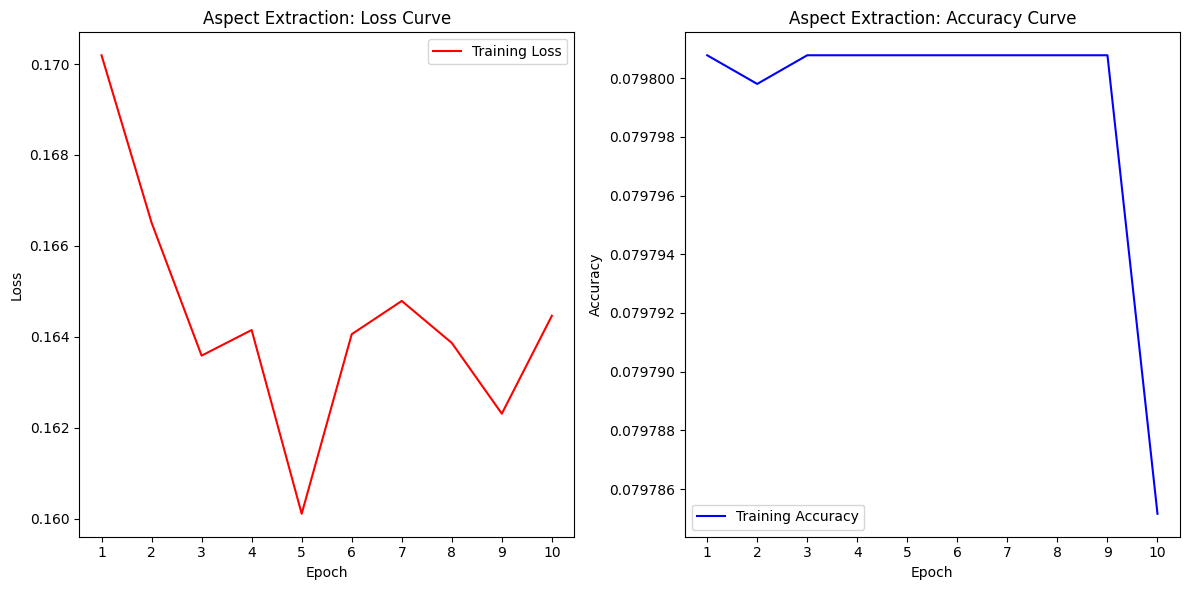

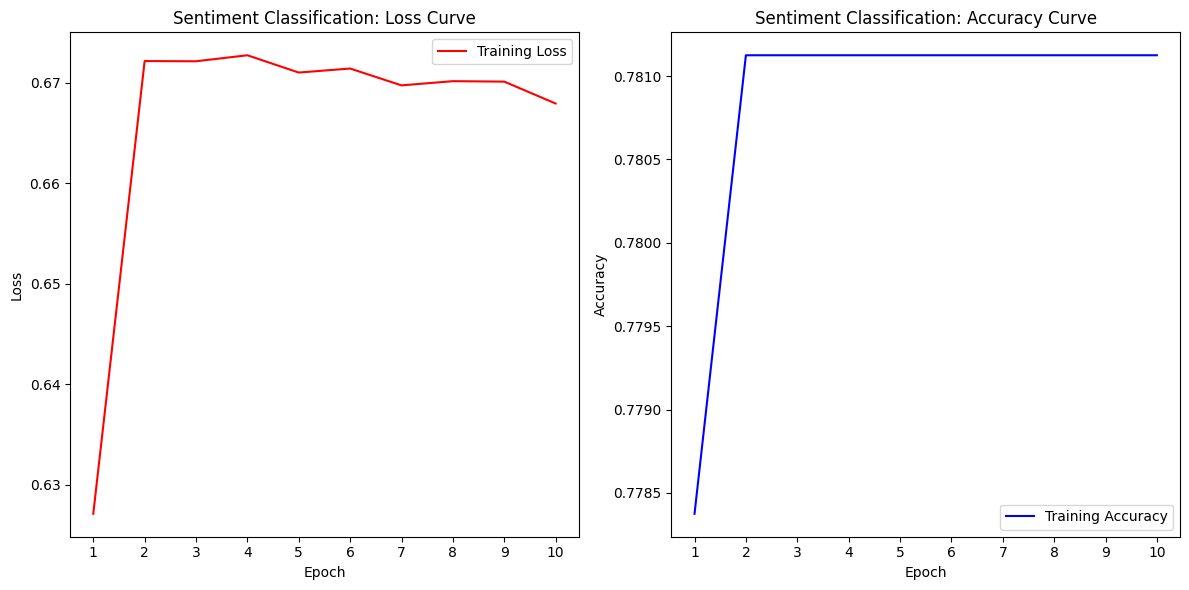

In [62]:
# Plot for Aspect Extraction
plot_training_curves(
    train_losses=aspect_train_losses,
    train_accuracies=aspect_train_accuracies,
    title="Aspect Extraction"
)

# Plot for Sentiment Classification
plot_training_curves(
    train_losses=sentiment_train_losses,
    train_accuracies=sentiment_train_accuracies,
    title="Sentiment Classification"
)
